In [5]:
import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_landing_data as pro_rd

import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const

#from models.rnn_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

#from estimation_study import *
from assessments.visualization import *
#import pdb
import re

import logging
logging.basicConfig(level=logging.ERROR)


# Original dataset

## Loadining results of original dataset

In [6]:
##### 1) load result path list
result_folders = read_result_folder_file("all_test_cases.txt")
#result_folders = read_result_folder_file("da_e_rotation.txt")

combination_investigation_results = [os.path.join(RESULTS_PATH, "training_testing", result_folder,"testing_result_folders.txt")
                                   for result_folder in result_folders]
# 2) get testing metrics
combination_investigation_results = [os.path.join(os.path.dirname(folder), "metrics.csv") if(os.path.exists(os.path.join(os.path.dirname(folder), "metrics.csv"))) else folder for folder in combination_investigation_results]
#print(combination_investigation_results)

# 3) collected or read or load metrics
if True:
    # load new metrics
    raw_metrics = get_list_investigation_metrics(combination_investigation_results)
    # save the new metrics
    raw_metrics.to_hdf('./raw_metrics.csv')
else:
    # load old metrics
    raw_metrics = pd.read_csv('./raw_metrics.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/workspace/drop_landing_workspace/results/training_testing/all_test_cases.txt'

In [3]:
!ls -al

total 113968
drwxrwxr-x 6 user user      4096 Dec 12 22:46 .
drwxrwxr-x 9 user user       325 Nov 29 14:46 ..
drwxrwxr-x 5 user user        60 Dec 11 16:19 data_visulization
-rw-rw-r-- 1 user user      4936 Nov 27 16:11 develop.py
drwxrwxr-x 2 user user       193 Dec  5 11:57 .ipynb_checkpoints
-rw-rw-r-- 1 user user     21300 Nov 27 16:11 NARX.ipynb
-rw-rw-r-- 1 user user    541337 Nov 27 16:11 P5_figure_results.ipynb
-rw-rw-r-- 1 user user     78789 Nov 27 16:11 P5_hyperparams_search.ipynb
-rw-rw-r-- 1 user user     47444 Nov 27 16:11 P5_table_results.ipynb
-rw-rw-r-- 1 user user    233656 Nov 27 16:11 P6_figure_results_v1.ipynb
-rw-rw-r-- 1 user user   1094652 Dec 12 22:46 P6_figure_results_v2.ipynb
-rw-rw-r-- 1 user user    857905 Dec 12 21:45 P6_figure_results_v3.ipynb
-rw-rw-r-- 1 user user    593496 Nov 27 16:11 P7_figure_results_v1.ipynb
-rw-rw-r-- 1 user user     17920 Nov 27 16:11 .png
drwxrwxr-x 3 user user       281 Nov 27 16:11 preprocess_rawdata
drwxrwxr-x 2 user user    

## Get metrics

In [ ]:
filters={'drop_value':0.4}
metrics = parse_list_investigation_metrics(combination_investigation_results,**filters)

## Plots

### influence of subject number

DROP r2 cases below :0.2


<Figure size 640x480 with 0 Axes>

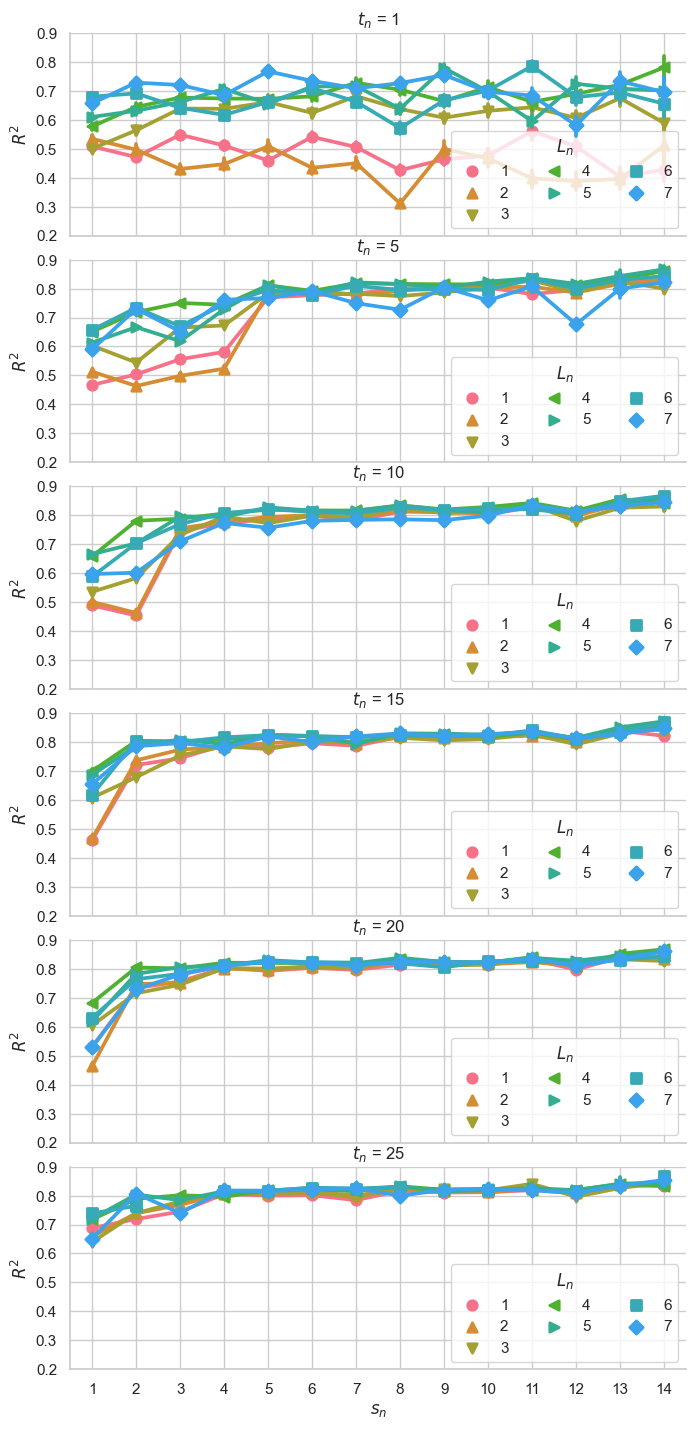

In [12]:
'''
Plot the points to show the influence of the subjects

'''
def p6_plot_subject_influence(data, rename_dict={},config={},filters={},figwidth=7,figheight=14):
    # theme
    sns.set(font_scale=1.0,style='whitegrid')
    sns.despine()
    states_palette = sns.color_palette()
    
    metrics = copy.deepcopy(data)
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)
        
    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    #metrics['LSTM layer number']= metrics['LSTM layer number'].astype(int)
    
    # plot
    g = sns.catplot(data=metrics, **config)
    axes = g.axes.reshape(g.axes.size,1)
    for idx in range(axes.size):
        axes[idx,0].set_yticks([0.2,0.3, 0.4, 0.5,0.6, 0.7, 0.8,0.9])
        axes[idx,0].xaxis.grid(True)
        axes[idx,0].yaxis.grid(True)
        #axes[idx,0].set_title('Trial number = {}'.format((idx+1)*5))
        axes[idx,0].legend(title=r'$L_n$',loc='lower right',ncol=3)
        axes[idx,0].set_ylim([0.2,0.9])
        
        
    # set figure size    
    g.fig.set_figwidth(figwidth)
    g.fig.set_figheight(figheight)
    
    # save figure
    fig_path=os.path.join(RESULTS_PATH, "visualization/P6/")
    #fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")

    save_figure("./",fig_format='svg')
    #save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)

    
rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$"}
plot_config={
    'y': r'$R^2$',
    'x': r'$s_n$',
    'kind': 'point',
    'height': 4,
    'aspect': 2,
    'sharey': True,
    'hue': r'$L_n$',
    #'row': 'train_sub_num',
    'col': r'$t_n$',
    'col_wrap': 1,
    'color':'0.5', # for bar
    "palette": sns.color_palette("husl", 9), # for hue,
    "errorbar":'sd',
    "markers":['o',"^","v","<",">","s","D","d"],
    'legend':False
}
filters={"drop_value":0.2}
p6_plot_subject_influence(raw_metrics, rename_dict, plot_config, filters=filters)

### Influence of trial number

$DROP R^2 cases below :0.3$


<Figure size 640x480 with 0 Axes>

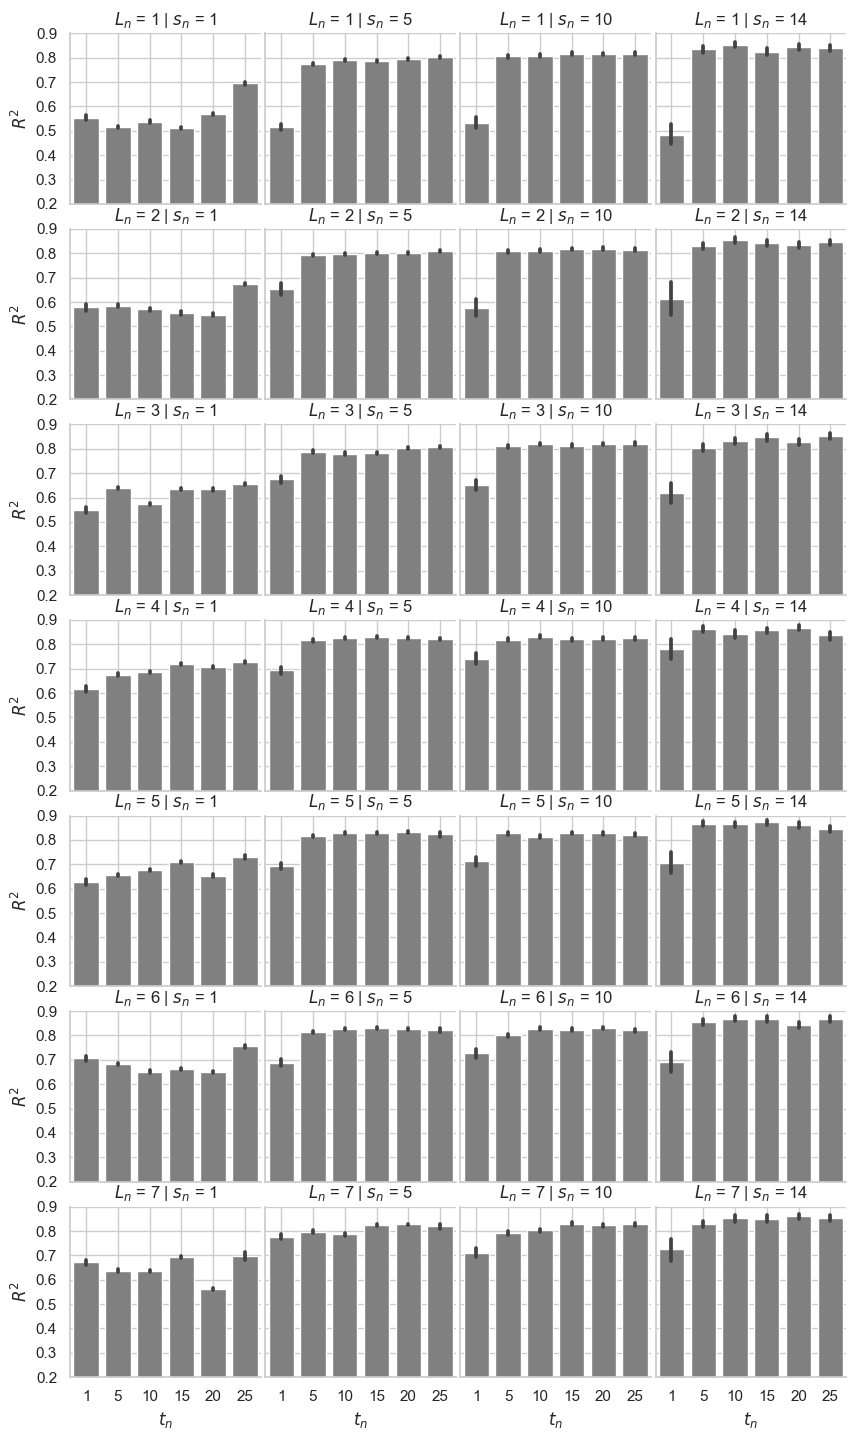

In [65]:

def p6_plot_points(metrics, rename_dict={}, config={}, filters={},figwidth=8,figheight=14):    
    
    # set theme
    sns.set(font_scale=1.0,style='whitegrid')
    sns.despine()
    states_palette = sns.color_palette()
    colors = sns.color_palette("husl", 9)

    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    #metrics['LSTM layer number']= metrics['LSTM layer number'].astype(int)
    #metrics['LSTM layer number']= metrics['LSTM layer number'].astype(int)
    
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)  
    
    g = sns.catplot(data=metrics, **config)
    axes = g.axes.reshape(g.axes.size,1)
    for idx in range(axes.size):
        axes[idx,0].set_yticks([0.2,0.3, 0.4, 0.5,0.6, 0.7, 0.8,0.9])
        axes[idx,0].xaxis.grid(True)
        axes[idx,0].yaxis.grid(True)
        #axes[idx,0].set_title(r'$l_n$={}| $n_1$={}'.format((idx+1)*5))
        #axes[idx,0].legend(title='LSTM layer number',loc='lower right',ncol=2)
        axes[idx,0].set_ylim([0.2,0.9])
    #plt.show()
    
    g.fig.set_figwidth(figwidth)
    g.fig.set_figheight(figheight)

    fig_path=os.path.join(RESULTS_PATH, "visualization/P6/")
    #fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")

    
    save_figure("./",fig_format='svg')
    #save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)

    
rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$"}
plot_config={
    'y': r"$R^2$",
    'x': r'$t_n$',
    'kind': 'bar',
    'height': 4,
    'aspect': 2,
    'sharey': True,
    #'hue': 'feature_layer_num',
    'row': r'$L_n$',
    'col': r'$s_n$',
    #'col_wrap': 2,
    'color': '0.5', # for bar
    'dodge': False # for bar
    #"palette": colors # for hue,
    #"errorbar":'sd',
    #"markers":['o',"^","v","<",">","s","D","d"],
    #'legend':False
}

filters= {r'$L_$':[1,2,3,4,5,6,7],r"$s_n$":[1,5,10,14],'drop_value':0.3}


p6_plot_points(raw_metrics, rename_dict, plot_config, filters=filters)

### Influence of LSTM layers

$DROP R^2 cases below :0.2$


<Figure size 640x480 with 0 Axes>

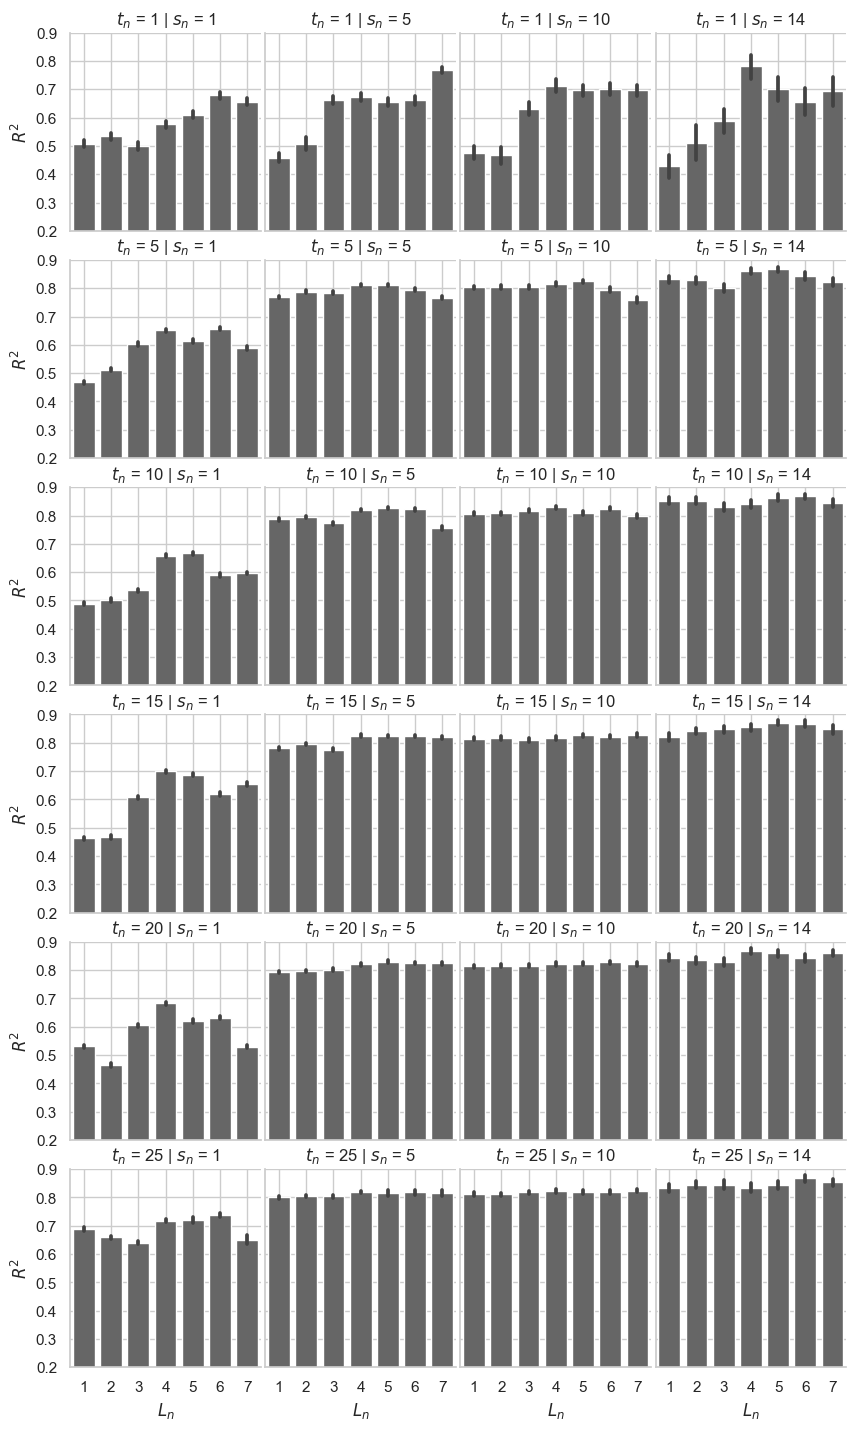

In [66]:
# plot bars
def plot_bars(metrics,rename_dict={}, config={},filters={},figwidth=8,figheight=14):
    # set theme
    sns.set(font_scale=1.0,style='whitegrid')
    sns.despine()
    states_palette = sns.color_palette()
    colors = sns.color_palette("husl", 9)

    
    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)
    
    g = sns.catplot(data=metrics, **config)
    axes = g.axes.reshape(g.axes.size,1)
    # format figure
    for idx in range(axes.size):
        axes[idx,0].set_yticks([0.2,0.3, 0.4, 0.5,0.6, 0.7, 0.8,0.9])
        axes[idx,0].xaxis.grid(True)
        axes[idx,0].yaxis.grid(True)
        #axes[idx,0].set_title('Trial number = {}'.format((idx+1)*5))
        #axes[idx,0].legend(title='LSTM layer number',loc='lower right',ncol=2)
        axes[idx,0].set_ylim([0.2,0.9])
    
        # statistical test
        #test_method="Mann-Whitney"
        test_method="t-test_ind"
        pairs = [
        (1,2),(2,3),(3,4),(4,5),(5,6),(6,7)
        ]
        #annotator = Annotator(axes[idx,0],pairs=pairs,data=metrics, **config)
        #annotator.configure(test=test_method, text_format='star', loc='inside',line_height=-0.03,line_offset=0.2,line_width=0.9,line_offset_to_group=-0.04)
        #annotator.apply_and_annotate()
    
    
    
    g.fig.set_figwidth(figwidth)
    g.fig.set_figheight(figheight)
    
    save_format='svg'
    fig_path ="./"
    save_figure("./",fig_format=save_format)
    #fig_path=os.path.join(RESULTS_PATH, "visualization/P6/")
    #fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")
    #save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)
    
    
    
rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$"}
config={
        'y': r'$R^2$',
        'x':r'$L_n$',
        'kind': 'bar',
        'height': 4,
        'aspect': 2,
        'sharey': True,
        #'hue': 'train_sub_num',
        'col': r'$s_n$',
        'row': r'$t_n$',
        #'col_wrap': 1,
        'color':'0.4', # for bar
        #"palette": "0.5", # for hue,
        #"errorbar":'sd',
        'dodge': False, # for bar
        #"markers":['o',"^","v","<",">","s","D","d"],
        'legend':False
}
filters={r'$s_n$':[1, 5, 10, 14], r'$t_n$':[1, 5, 10, 15, 20, 25], 'drop_value':0.2}
#filters={}
plot_bars(raw_metrics, rename_dict,config,filters)



### Plot bars of subject number

Figure. The influence of the number of LSTM layer on the estimation accuracy under the diffrent number of subjects and trials. 

### Plot heatmap of the original dataset

$DROP R^2 cases below :0.3$


/tmp/ipykernel_6229/770468231.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = metrics[[vary,varx,value]].groupby([varx,vary]).median().round(2).reset_index().pivot(varx,vary)[value]


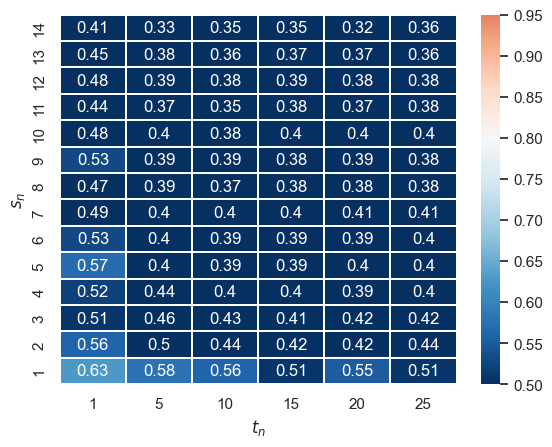

<AxesSubplot: xlabel='$t_n$', ylabel='$s_n$'>

In [216]:
# plot the heatmap

def p6_plot_heatmap(metrics,rename_dict={}, config={}, filters={}):
        
    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    #metrics['LSTM layer number']= metrics['LSTM layer number'].astype(int)
        
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)
        
    varx=config['varx']; vary=config['vary']; value=config['value']
    #metrics[varx].replace({idx:idx-4 for idx in range(5,len(combination_investigation_results)+1)},inplace=True)
    data = metrics[[vary,varx,value]].groupby([varx,vary]).median().round(2).reset_index().pivot(varx,vary)[value]
    g = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.85,annot=True,linewidths=0.3)# R^2
    #g = sns.heatmap(data, vmin=0.04, vmax=0.2,cmap="RdBu",center=0.1,annot=True,linewidths=0.3)#rRMSE
    #g = sns.heatmap(data, vmin=0.2, vmax=0.7,cmap="RdBu",center=0.4,annot=True,linewidths=0.3) # RMSE
    g.invert_yaxis()
    #g.set_ylabel(ylabel)
    #g.set_xlabel(xlabel)
    
    
    save_format='svg'
    fig_path ="./"
    save_figure("./",fig_format=save_format)
    return g 



rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$",'rmse':"RMSE",'r_rmse':"rRMSE"}
filters={r'$L_n$':[4],'drop_value':0.3} # 0.0; 0.2;0.4

config={
'varx':r'$s_n$',
    'vary':r'$t_n$',
    #'value':r'$R^2$',
    'value':r'RMSE',
   #'value':'rRMSE',
}

p6_plot_heatmap(raw_metrics,rename_dict,config,filters)

### Display model complexity

In [72]:
# get result folders
result_folders = read_result_folder_file("time_complexity.txt")
combination_investigation_results=[os.path.join(RESULTS_PATH, "training_testing", result_folder,"testing_result_folders.txt")
                                   for result_folder in result_folders]

# 2) get testing metrics
combination_investigation_results = [os.path.join(os.path.dirname(folder), "metrics.csv") if(os.path.exists(os.path.join(os.path.dirname(folder), "metrics.csv"))) else folder for folder in combination_investigation_results]
#print(combination_investigation_results)
time_complexity_metrics = get_list_investigation_metrics(combination_investigation_results)


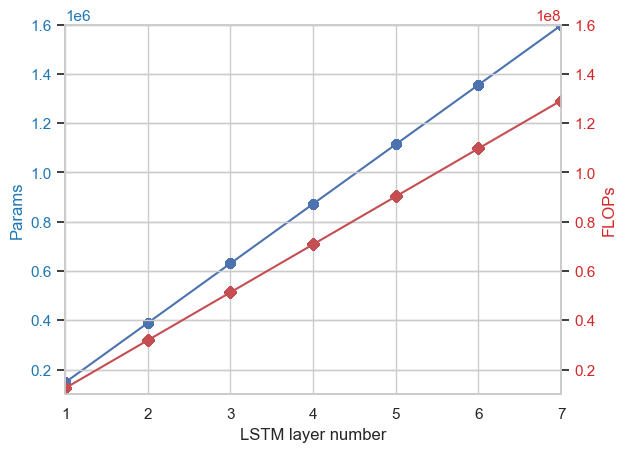

In [32]:
# Model complexity visualization
def plot_time_complexity(metrics,figpath="./"):
    metrics['FLOPs']=metrics['FLOPs'].astype(float)
    metrics['FLOPs']=metrics['FLOPs']#/1000000.0
    metrics['feature_layer_num'].astype(float)
    filter_metrics = metrics[['FLOPs', 'Params','feature_layer_num','r2']]
    #sns.scatterplot(data=filter_metrics,x='feature_layer_num',y='FLOPs')
    #sns.scatterplot(data=filter_metrics,x='feature_layer_num',y='Params')
    ax = filter_metrics.plot(x="feature_layer_num", y="Params", legend=False,marker='o')
    ax.set_ylim(0.1e6,1.6e6)
    ax.set_ylabel('Params', color='tab:blue')  # we already handled the x-label with ax1
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax.twinx()
    filter_metrics.plot(x="feature_layer_num", y="FLOPs", ax=ax2, legend=False, color="r",marker='D')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0.1e8,1.6e8)
    ax2.set_ylabel('FLOPs', color='tab:red')  # we already handled the x-label with ax1
    ax.set_xlabel('LSTM layer number')  # we already handled the x-label with ax1
    ax.set_xticks([1,2,3,4,5,6,7])
    ax.set_xlim(min(filter_metrics['feature_layer_num']),max(filter_metrics['feature_layer_num']))
    #ax.figure.legend()
    save_format='svg'
    if(isinstance(metrics,list)):
        save_folder = os.path.dirname(metrics[0])
    else:# metrics is a data array
        save_folder = figpath
    save_figure(save_folder,fig_format=save_format)
    
plot_time_complexity(time_complexity_metrics)
#sns.scatterplot(data=filter_metrics, x='feature_layer_num',y='FLOPs')

In [91]:
max(time_complexity_metrics['feature_layer_num'])

7

In [33]:
print(metrics.columns)
selected_metrics=metrics[['dataset_name','train_sub_num','test_subjects','test_trial','model_name','r2','rmse','r_rmse','mae','feature_layer_num']]
selected_metrics.head(30)
#tmp = selected_metrics[selected_metrics['test_subjects'].isin(['P_16_zhangjinduo','P_14_hunan','P_11_liuchunyu','P_23_wangjinhong', 'P_24_liziqing'])].groupby(['test_subjects','test_trial']).median()
#tmp = selected_metrics[selected_metrics['test_subjects'].isin([ 'P_24_liziqing'])].groupby(['test_subjects','test_trial']).median()
tmp = selected_metrics.groupby(['test_subjects']).mean()
tmp.head(40)
#melt_metrics=selected_metrics.melt(id_vars=['dataset_name','train_sub_num','r2','feature_layer_num'])
#melt_metrics.head()


NameError: name 'metrics' is not defined

In [115]:
#1) get testing results: estimation and ground truth
print(combination_investigation_results)
results = get_list_investigation_results(combination_investigation_results)
print(results.columns)

#6) other fliters
def parse_dataframe(results, **kwargs):
    for key, value in kwargs.items():
        if(key in results.columns):
            try:
                if(not isinstance(value,list)):
                    value=[value]
                if set(value) <= set(results[key]): # a value of the test id
                    results = results.loc[results[key].isin(value)]
                elif(value=='all'):
                    print('All {} are used'.format(key))
                else:
                    print('{} is not right, it should be {}'.format(key, set(results[key])))
            except Exception as e:
                pdb.set_trace()
    return results

fliters = {
    'test_subjects':['P_08_zhangboyuan'],
    'test_folder_index':[1],
    'trial_index': [6],
}
data = parse_dataframe(results,**fliters)

plt.plot(data['Actual R_KNEE_MOMENT_X'],'k-.')
plt.plot(data['Estimated R_KNEE_MOMENT_X'],'r-.')
plt.legend(['actual', 'estimated'])
plt.grid()
plt.show()

['/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_1_original_7_15_25_R_KNEE_MOMENT_X_ori_v2/metrics.csv', '/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_2_original_7_15_25_R_KNEE_MOMENT_X_ori_v2/metrics.csv', '/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_3_original_7_15_25_R_KNEE_MOMENT_X_ori_v2/metrics.csv', '/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_4_original_7_15_25_R_KNEE_MOMENT_X_ori_v2/metrics.csv', '/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_5_original_7_15_25_R_KNEE_MOMENT_X_ori_v2/metrics.csv', '/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_6_original_7_15_25_R_KNEE_MOMENT_X_ori_v2/metrics.csv', '/media/sun/TFcard/drop_landing_workspace/results/training_testing/rdouble_leg_v1_baseline_7_original_7_15_25_R_KNEE_

KeyError: 'training_testing_folders'

In [43]:
print(data.shape)
data.head()

(80, 5)


,Actual R_KNEE_MOMENT_X,Estimated R_KNEE_MOMENT_X,trial_index,test_subject,test_folder_index
0.00,-0.03616,0.475870,0,None,0
0.01,-0.03533,0.379049,0,None,0
0.02,-0.03207,0.329380,0,None,0
0.03,-0.02958,0.307361,0,None,0
0.04,-0.03192,0.298069,0,None,0


# New augmentation

In [6]:
## load results of the augmentation method

In [36]:
# 1) load results of the augmentation method
result_folders = read_result_folder_file("augmentation_test_cases.txt")

combination_investigation_results=[os.path.join(RESULTS_PATH, "training_testing", result_folder,"testing_result_folders.txt")
                                   for result_folder in result_folders]
# 2) get testing metrics
combination_investigation_results = [os.path.join(os.path.dirname(folder), "metrics.csv") if(os.path.exists(os.path.join(os.path.dirname(folder), "metrics.csv"))) else folder for folder in combination_investigation_results]
#print(combination_investigation_results)
    
# 3) collected or read or load metrics
if True:
    # load new metrics
    augment_raw_metrics = get_list_investigation_metrics(combination_investigation_results)
    # save the new metrics
    augment_raw_metrics.to_csv('./augment_raw_metrics.csv')
else:
    # load old metrics
    augmnet_raw_metrics = pd.read_csv('./augment_raw_metrics.csv')

### Plot the heatmap

$DROP R^2 cases below :0.4$


/tmp/ipykernel_6229/3609587174.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = metrics[[vary,varx,value]].groupby([varx,vary]).median().round(2).reset_index().pivot(varx,vary)[value]


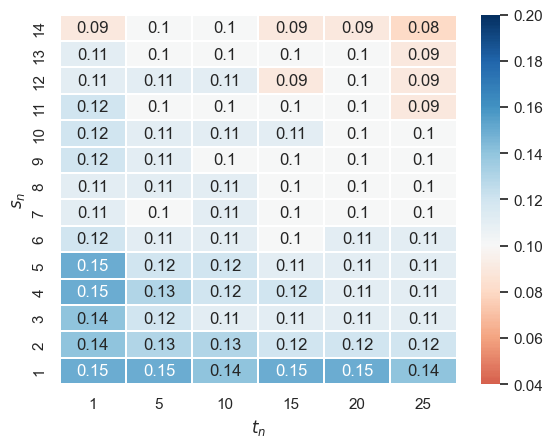

<AxesSubplot: xlabel='$t_n$', ylabel='$s_n$'>

In [231]:
# plot the heatmap

def p6_plot_heatmap(metrics,rename_dict={}, config={}, filters={}):
        
    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    #metrics['LSTM layer number']= metrics['LSTM layer number'].astype(int)
        
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)
        
    varx=config['varx']; vary=config['vary']; value=config['value']
    #metrics[varx].replace({idx:idx-4 for idx in range(5,len(combination_investigation_results)+1)},inplace=True)
    data = metrics[[vary,varx,value]].groupby([varx,vary]).median().round(2).reset_index().pivot(varx,vary)[value]
    #g = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.8,annot=True,linewidths=0.3)# R^2
    #g = sns.heatmap(data, vmin=0.2, vmax=0.7,cmap="RdBu",center=0.4,annot=True,linewidths=0.3) # RMSE
    g = sns.heatmap(data, vmin=0.04, vmax=0.2,cmap="RdBu",center=0.1,annot=True,linewidths=0.3)#rRMSE
    g.invert_yaxis()
    #g.set_ylabel(ylabel)
    #g.set_xlabel(xlabel)
    
    
    save_format='svg'
    fig_path ="./"
    save_figure("./",fig_format=save_format)
    return g 


rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$",'rmse':"RMSE",'r_rmse':"rRMSE"}
filters={r'$L_n$':[4],'drop_value':0.4,'dataset_name':'CTD'}

config={
'varx':r'$s_n$',
    'vary':r'$t_n$',
    #'value':r'$R^2$',
    #'value':'RMSE',
    'value':'rRMSE',
}

augment_raw_metrics.replace({'original':'MD','e_scale':'PTD','e_rotation':'OTD','e_rotation_e_scale':'CTD'},inplace=True)
p6_plot_heatmap(augment_raw_metrics,rename_dict,config,filters)

## Comparison of original, e_rotation, e_scale, and e_rotation with e_scale

In [247]:
# plot bars fo subjects
def p6_plot_comparison(metrics, rename, config, filters={},test_config={},figwidth=10,figheight=14):

    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)
        
        
    # set theme of plot
    sns.set(font_scale=1.0,style='whitegrid')
    sns.despine()
    states_palette = sns.color_palette()
    colors = sns.color_palette("husl", 9)
    
    
    # sort values
    sort_metrics = metrics.sort_values(by=config['y'], ascending=False)
    
    g = sns.catplot(data=sort_metrics, **config)
    axes = g.axes.reshape(g.axes.size,1)
    # format figure
    for idx in range(axes.size):
        axes[idx,0].set_yticks([0.5,0.6, 0.7, 0.8,0.9])
        axes[idx,0].xaxis.grid(True)
        axes[idx,0].yaxis.grid(True)
        #axes[idx,0].set_title('Trial number = {}'.format((idx+1)*5))
        axes[idx,0].legend(title='Dataset',loc='lower right',ncol=2)
        axes[idx,0].set_ylim([0.5,0.9])
    
        # statistical test
        if(test_config not in [None, {}]):
            test_method="Mann-Whitney"
            #test_method="t-test_ind"
            annotator = Annotator(axes[idx,0],pairs=test_config['test_pairs'],data=metrics, **config)
            annotator.configure(test=test_method, text_format='star', loc='inside',line_height=-0.03,line_offset=0.1,line_width=0.9,line_offset_to_group=-0.04)
            annotator.apply_and_annotate()
    
    
    
    g.fig.set_figwidth(figwidth)
    g.fig.set_figheight(figheight)
    
    save_format='svg'
    fig_path ="./"
    save_figure("./",fig_format=save_format)
    #fig_path=os.path.join(RESULTS_PATH, "visualization/P6/")
    #fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")
    #save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)
    
    
    
rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$", 'dataset_name': "Dataset method"}
config={
        'y': r'$R^2$',
        'x': r'$s_n$',
        'kind': 'bar',
        #'height': 4,
        #'aspect': 2,
        'sharey': True,
        'hue': 'Dataset method',
        #'row': r'$s_n$',
        'col': r'$t_n$',
        'col_wrap': 1,
        #'color':'0.4', # for bar
        #"palette": "0.5", # for hue,
        #"errorbar":'sd',
        #"markers":['o',"^","v","<",">","s","D","d"],
        #'dodge': False, # for bar
        'hue_order': ['MD','OTD','PTD','CTD'],
        'legend':False
}

test_config={
"test_pairs": [
        [(1,'MD'),(1,'OTD')]
        ]
}

all_metrics=pd.concat([raw_metrics, augment_raw_metrics])


all_metrics.replace({'original':'MD','e_scale':'PTD','e_rotation':'OTD','e_rotation_e_scale':'CTD'},inplace=True)
#filters={r'$L_n$':[4], r'$t_n$':[10,15,20,25],r'$s_n$':[idx for idx in range(6,15)],"drop_value":0.4}
filters={r'$L_n$':[4], r'$t_n$':[1,5,10,15,20,25],r'$s_n$':[idx for idx in range(1,15)],"drop_value":0.4}
#p6_plot_comparison(all_metrics, rename_dict, config, filters,test_config={})

### compare a trial of different dataset 

$DROP R^2 cases below :0.4$
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MD vs. OTD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.766e-02 U_stat=1.411e+06
MD vs. PTD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.383e-01 U_stat=1.451e+06
MD vs. CTD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.530e-02 U_stat=1.479e+06
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MD vs. OTD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.766e-02 U_stat=1.411e+06
MD vs. PTD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.383e-01 U_stat=1.451e+06
MD vs. CTD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.530e-02 U_stat=1.479e+06
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 

<Figure size 640x480 with 0 Axes>

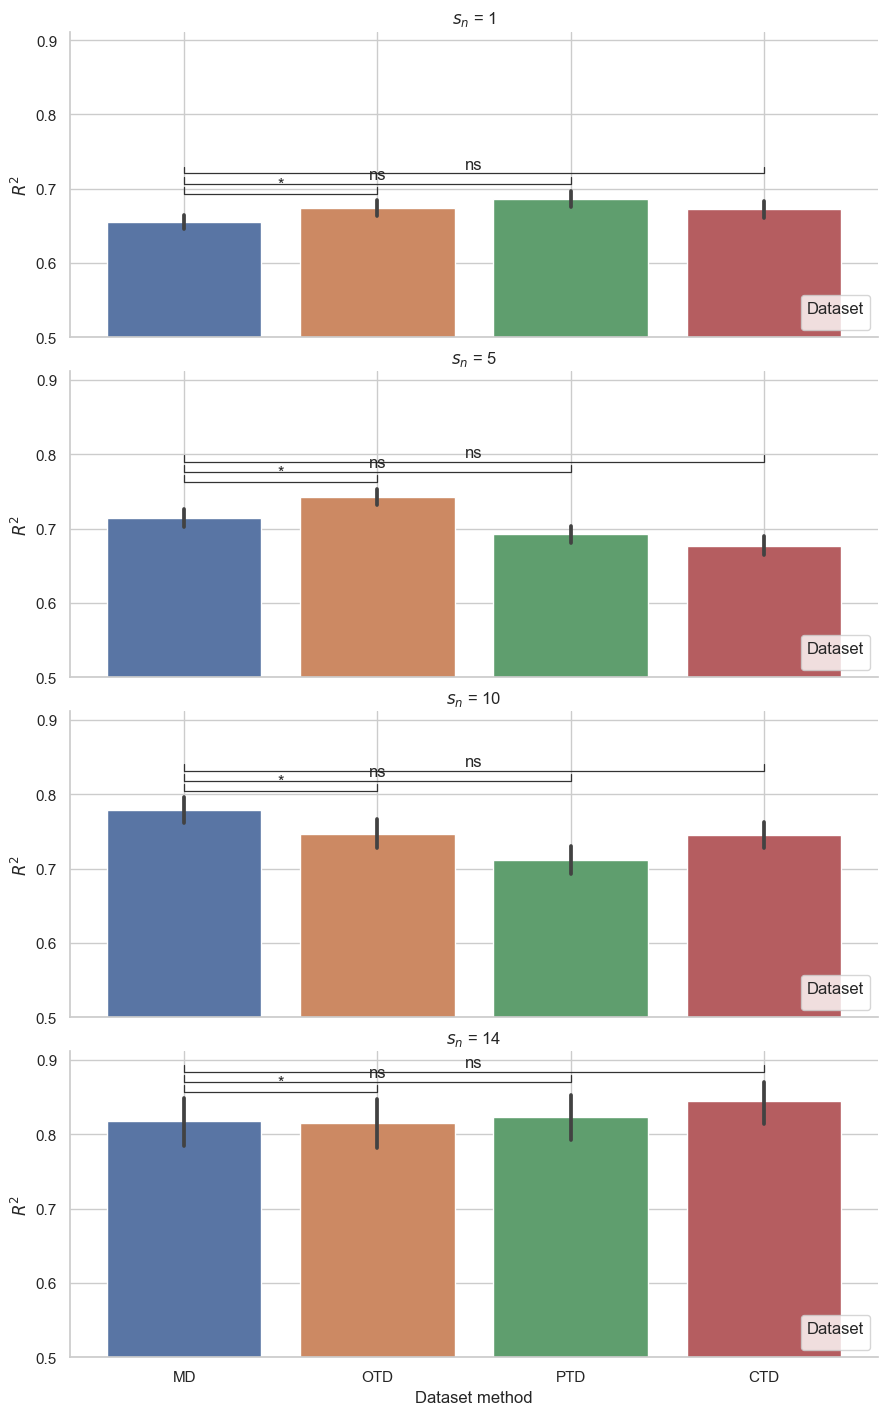

In [255]:

# plot bars fo subjects
def p6_plot_comparison(metrics, rename, config, filters={},test_config={},figwidth=10,figheight=14):

    # rename column name:
    if(rename_dict not in [{},None]):
        metrics = metrics.rename(columns=rename_dict)
    
    # filter metrics
    if filters!={}:
        metrics = filter_metrics(metrics,**filters)
        
        
    # set theme of plot
    sns.set(font_scale=1.0,style='whitegrid')
    sns.despine()
    states_palette = sns.color_palette()
    colors = sns.color_palette("husl", 9)
    
    
    # sort values
    sort_metrics = metrics.sort_values(by=config['y'], ascending=False)
    
    g = sns.catplot(data=sort_metrics, **config)
    axes = g.axes.reshape(g.axes.size,1)
    # format figure
    for idx in range(axes.size):
        axes[idx,0].set_yticks([0.5,0.6, 0.7, 0.8,0.9])
        axes[idx,0].xaxis.grid(True)
        axes[idx,0].yaxis.grid(True)
        #axes[idx,0].set_title('Trial number = {}'.format((idx+1)*5))
        axes[idx,0].legend(title='Dataset',loc='lower right',ncol=2)
        axes[idx,0].set_ylim([0.5,0.8])
    
        # statistical test
        if(test_config not in [None, {}]):
            test_method="Mann-Whitney"
            #test_method="t-test_ind"
            annotator = Annotator(axes[idx,0],pairs=test_config['test_pairs'],data=metrics, **config)
            annotator.configure(test=test_method, text_format='star', loc='inside',line_height=-0.03,line_offset=0.1,line_width=0.9,line_offset_to_group=-0.04)
            annotator.apply_and_annotate()
    
    
    
    g.fig.set_figwidth(figwidth)
    g.fig.set_figheight(figheight)
    
    save_format='svg'
    fig_path ="./"
    save_figure("./",fig_format=save_format)
    #fig_path=os.path.join(RESULTS_PATH, "visualization/P6/")
    #fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")
    #save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)
    
    

rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$", 'dataset_name': "Dataset method"}
config={
        'y': r'$R^2$',
        'x': r'Dataset method',
        'kind': 'bar',
        #'height': 4,
        #'aspect': 2,
        'sharey': True,
        #'hue': 'Dataset method',
        'row': r'$s_n$',
        #'col': r'$t_n$',
        #'col_wrap': 1,
        #'color':'0.4', # for bar
        #"palette": "0.5", # for hue,
        #"errorbar":'sd',
        #"markers":['o',"^","v","<",">","s","D","d"],
        #'dodge': False, # for bar
        'order': ['MD','OTD','PTD','CTD'],
        #'legend':False
}

test_config={
"test_pairs": [
        ['MD','OTD'],['MD','PTD'],['MD','CTD']
        ]
}

all_metrics=pd.concat([raw_metrics, augment_raw_metrics])


all_metrics.replace({'original':'MD','e_scale':'PTD','e_rotation':'OTD','e_rotation_e_scale':'CTD'},inplace=True)
#filters={r'$L_n$':[4], r'$t_n$':[10,15,20,25],r'$s_n$':[idx for idx in range(6,15)],"drop_value":0.4}
filters={r'$L_n$':[4], r'$t_n$':[1],r'$s_n$':[1,5,10,14],"drop_value":0.4}
p6_plot_comparison(all_metrics, rename_dict, config, filters,test_config)

In [166]:


# rename column name:
rename_dict = {'train_sub_num':r'$s_n$', 'tre_trial_num':r'$t_n$','feature_layer_num':r'$L_n$','r2':r"$R^2$", 'dataset_name': "Dataset method"}
if(rename_dict not in [{},None]):
    tmp_metrics = all_metrics.rename(columns=rename_dict)
    
filter1={r'$L_n$':[4], r'$t_n$':[1],"Dataset method":['MD'],"drop_value":0.1}
tmp_metrics = filter_metrics(tmp_metrics,**filter1)
sns.barplot(tmp_metrics,x=r'$s_n$',y=r"$R^2$")


$DROP R^2 cases below :0.1$


/home/sun/.pyenv/versions/3.9.2/envs/machinelearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input '$R^2$'

In [165]:
tmp_metrics[r'$R^2$']

1339456    0.891
1339457    0.881
1339458    0.763
1339459    0.569
1339460    0.703
           ...  
1347325    0.643
1347326    0.608
1347327    0.413
1347328    0.567
1347329    0.616
Name: $R^2$, Length: 7381, dtype: float64

# Tables

# Others

In [44]:
raw_metrics.columns

Index(['Unnamed: 0', 'landing_manner', 'model_name', 'feature_layer_num',
       'dataset_name', 'alias_name', 'config_name', 'subject_num',
       'tre_trial_num', 'tst_trial_num', 'train_sub_num', 'features_name',
       'labels_name', 'r2', 'rmse', 'r_rmse', 'mae', 'FLOPs', 'Params',
       'test_subjects', 'test_trial', 'parent_test_id', 'child_test_id',
       'result_folder', 'Test ID', 'Metrics ID', 'IMUs', 'execution_time',
       'additional_imus'],
      dtype='object')

## Baseline

### Baseline curves

In [17]:
## Plot estimation curves


combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","baseline_mlnn_v11_5",str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [1] for trial_num in [5]
]+[
    os.path.join(RESULTS_PATH, "training_testing","baseline_mlnn_v11_5",str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [14] for trial_num in [25]]

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v18",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(15,16,1) for trial_num in range(5, 6,5) for rot_id in [0]
]


combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_kam_v20",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(4,5,1) for trial_num in range(5, 16,5) for rot_id in [0]
]


combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_dkem_v8",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [6]
]


combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_skem_v8",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(9,10,1) for trial_num in range(10,11,5) for rot_id in [6]
]




combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing", "augmentation_v9","testing_result_folders.txt"),
    os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v9","testing_result_folders.txt")
]


metrics = get_list_investigation_metrics(combination_investigation_results)
combination_investigation_metrics = [os.path.join(os.path.dirname(folder), "metrics.csv") for folder in combination_investigation_results]
fig_path, r2 = plot_models_accuracy(combination_investigation_results,plot_params={'x':'config_name','y':'r2','hue':'labels_name'})


multi_test_results = get_multi_models_test_results(combination_investigation_results)

config = {
    'xticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'yticks':[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'ylim':[-1.0, 3.0],
    'figsize': (8,3),
    'ylabels': 5*['Normalized KFM'],
    'titles': ['A subject with five trials', '14 subjects with 25 trials'],
    'font_scale':1.0, 
    'save_fig': True,
    #'fig_path': os.path.join(RESULTS_PATH,"training_testing/visualization/P6","Fig_results_baseline_curves.svg"),
    'save_format': '.svg'
}

figpath, multi_model_results = p6plot_statistic_actual_estimation_curves(combination_investigation_results, col_wrap=2, **config)

/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v9/testing_result_folders.txt


FileNotFoundError: [Errno 2] No such file or directory: '/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v9/testing_result_folders.txt'

/home/sun/workspace/PythonProject/DataAnalysis/P6/transfer_learning_for_droplanding/assessments/./../../../CRCF/plot_utilities.py:45: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(figPath)
/home/sun/.pyenv/versions/3.9.2/envs/machinelearning/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


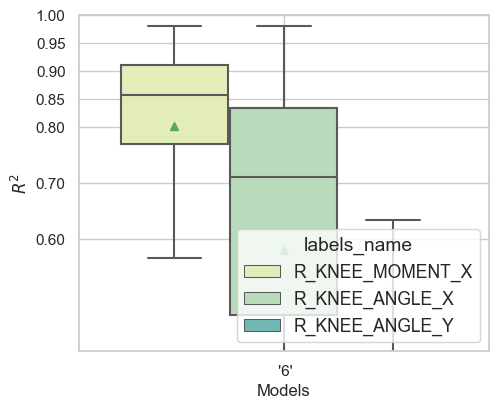

In [46]:

fig_path, r2 = plot_models_accuracy(combination_investigation_results,plot_params={'x':'config_name','y':'r2','hue':'labels_name'})

In [47]:
metrics.head()
metrics['r2']=metrics['r2'].astype(float)

In [48]:
metrics.groupby(['labels_name','model_selection','train_sub_num','trial_num','landing_manner']).mean()

/tmp/ipykernel_30398/1811341978.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metrics.groupby(['labels_name','model_selection','train_sub_num','trial_num','landing_manner']).mean()


r2  \
labels_name     model_selection train_sub_num trial_num landing_manner            
R_KNEE_ANGLE_X  augmentation    3             10         single_leg     0.40287   
                                6             10         single_leg     0.62331   
                                9             10         single_leg     0.49845   
                baseline_mlnn   3             10         double_leg     0.56100   
                                                         single_leg     0.39692   
                                6             10         double_leg     0.82088   
                                                         single_leg     0.65805   
                                9             10         double_leg     0.67274   
                                                         single_leg     0.58999   
R_KNEE_ANGLE_Y  augmentation    3             10         single_leg    -2.67495   
                                6             10         single_leg    -3.71990   
                                9             10         single_leg    -3.80314   
                baseline_mlnn   3             10         single_leg    -2.68407   
                                6             10         single_leg    -2.89696   
                                9             10         single_leg    -3.47725   
R_KNEE_MOMENT_X augmentation    3             10         single_leg     0.74936   
                                6             10         single_leg     0.87066   
                                9             10         single_leg     0.74952   
                baseline_mlnn   3             10         double_leg     0.77814   
                                                         single_leg     0.73130   
                                6             10         double_leg     0.84098   
                                                         single_leg     0.89010   
                                9             10         double_leg     0.82307   
                                                         single_leg     0.79016   

                                                                        trials  \
labels_name     model_selection train_sub_num trial_num landing_manner           
R_KNEE_ANGLE_X  augmentation    3             10         single_leg        0.0   
                                6             10         single_leg        0.0   
                                9             10         single_leg        0.0   
                baseline_mlnn   3             10         double_leg        0.0   
                                                         single_leg        0.0   
                                6             10         double_leg        0.0   
                                                         single_leg        0.0   
                                9             10         double_leg        0.0   
                                                         single_leg        0.0   
R_KNEE_ANGLE_Y  augmentation    3             10         single_leg        0.0   
                                6             10         single_leg        0.0   
                                9             10         single_leg        0.0   
                baseline_mlnn   3             10         single_leg        0.0   
                                6             10         single_leg        0.0   
                                9             10         single_leg        0.0   
R_KNEE_MOMENT_X augmentation    3             10         single_leg        0.0   
                                6             10         single_leg        0.0   
                                9             10         single_leg        0.0   
                baseline_mlnn   3             10         double_leg        0.0   
                                                         single_leg        0.0   
                                6             10         double_leg        0.0   
                                

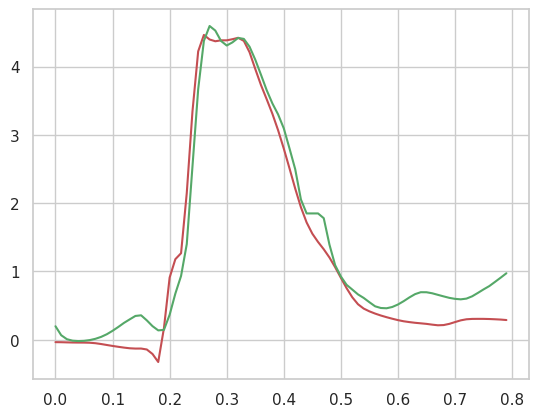

In [ ]:
pd_data = multi_test_results[0]
data =pd_data[pd_data['trial_index']==10]
data= data[data['test_subject']=='P_22_zhangning']
plt.plot(data['Actual R_KNEE_MOMENT_X'],'r')
plt.plot(data['Estimated R_KNEE_MOMENT_X'],'g')

In [11]:
set(multi_test_results[0]['test_subject'])

{'P_11_liuchunyu', 'P_15_liuzhaoyu', 'P_22_zhangning', 'P_23_wangjinhong'}

In [102]:
# plot extimation curve of a trial
print(combination_investigation_results[0],len(combination_investigation_results))
#testing_folder=
testing_folders =  get_investigation_training_testing_folders(combination_investigation_results[0])
testing_folder = testing_folders['testing_folders'][10]
[pd_labels, pd_predictions] = get_testing_results(testing_folder)
plot_prediction(pd_labels,pd_predictions,testing_folder,verbose=1)

/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v20/0rotid/1sub/5tri/testing_result_folders.txt 70


FileNotFoundError: [Errno 2] No such file or directory: '/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v20/0rotid/1sub/5tri/testing_result_folders.txt'

In [ ]:
multi_model_results

### baseline heatmap

In [101]:
# plot heatmap

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v11_5",
                str(sub_idx)+"sub", str(trial_idx)+"trials", 
                 "testing_result_folders.txt") for sub_idx in range(1,15,1) for trial_idx in range(5, 26,5)]

combination_investigation_results =  [#combination_investigation_results +[
    os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v18",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(1,15,1) for trial_num in range(5, 6,5) for rot_id in [0]
]

combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v20",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(1,15,1) for trial_num in range(5, 26,5) for rot_id in [0]
]

#combination_investigation_results =  [#combination_investigation_results +[
#            os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_kam_v20",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
#                 "testing_result_folders.txt") for sub_num in range(1,5,1) for trial_num in range(5, 16,5) for rot_id in [0]
#]



#metrics = get_list_investigation_metrics(combination_investigation_results)


combination_investigation_metrics = [os.path.join(os.path.dirname(folder), "metrics.csv") for folder in combination_investigation_results]
metric_index='r2'
filters={'drop_value':0.2,'sort_variable':metric_index}
baseline_metrics = parse_list_investigation_metrics(combination_investigation_metrics,calculate_mean_subject_r2=False,**filters)
data = baseline_metrics[['train_sub_num', 'trial_num', metric_index]].groupby(['train_sub_num','trial_num']).median().round(2).reset_index().pivot('train_sub_num','trial_num')[metric_index]
#data = baseline_metrics[['trial_num','train_sub_num','mean_subject_r2']].groupby(['train_sub_num','trial_num']).median().round(2).reset_index().pivot('train_sub_num','trial_num')['mean_subject_r2']
ax = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.8,annot=True,linewidths=0.3).invert_yaxis()
plt.ylabel('Subject number')
plt.xlabel('Trial number')
save_format='svg'
fig_path=os.path.join(RESULTS_PATH, "visualization/P6/Fig_results_baseline_heatmap.svg")
#fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")

save_figure(fig_path,fig_format=save_format)
#save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)


FileNotFoundError: [Errno 2] No such file or directory: '/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v20/0rotid/1sub/5tri/metrics.csv'

In [ ]:
# model estimation comparison

combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_pkem_v1",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [10]
]


#combination_investigation_results =  combination_investigation_results +[
#            os.path.join(RESULTS_PATH, "training_testing", "augmentation_pkem_v1",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
#                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [10]
#]
#
#
#combination_investigation_results =  combination_investigation_results +[
#            os.path.join(RESULTS_PATH, "training_testing", "augmentation_pkem_v1",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
#                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [5,20, 30, 40]
#]
#

combination_investigation_results =  combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_kem_v2",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [6, 7, 8,9,10,11]
]

#metrics = get_list_investigation_metrics(combination_investigation_results)


combination_investigation_metrics = [os.path.join(os.path.dirname(folder), "metrics.csv") for folder in combination_investigation_results]
fig_path, r2 = plot_models_accuracy(combination_investigation_results,plot_params={'x':'config_name','y':'r2','hue':'model_selection'})

In [ ]:
baseline_metrics.columns
set(baseline_metrics[(baseline_metrics['train_sub_num']==5) & (baseline_metrics['trial_num']==5)].sort_values(by=['r2'])['subjects'])

In [ ]:
baseline_metrics[(baseline_metrics['train_sub_num']==5) & (baseline_metrics['trial_num']==5)].sort_values(by=['r2'])#[['r2']]

In [ ]:
baseline_metrics[(baseline_metrics['train_sub_num']==5) & (baseline_metrics['trial_num']==5) & (baseline_metrics['subjects']=='P_08_zhangboyuan')].sort_values(by=['r2'])#[['r2']]

In [ ]:
baseline_metrics[(baseline_metrics['train_sub_num']>1)&(baseline_metrics['trial_num']>5)][['train_sub_num','trial_num','test_subject','r2','mean_subject_r2']].groupby(['train_sub_num','trial_num']).median()

In [ ]:
# table

filters={'drop_value':0.0,'sort_variable':'r2'}
baseline_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
baseline_metrics[['trial_num','train_sub_num','r2']][aug_metrics['trial_num'].isin([25])].groupby(['train_sub_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

In [ ]:
combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}
baseline_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
baseline_metrics['subject_num'].replace({idx:idx-4 for idx in range(5,11)},inplace=True)

baseline_metrics[['trial_num','subject_num','r2']][baseline_metrics['trial_num'].isin([25])].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T
#baseline_metrics[['trial_num','subject_num','r2']].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

## Augmentation

### Augmentation curves

provided fig_path is wrong, please give a complete path


UnboundLocalError: local variable 'figPath' referenced before assignment

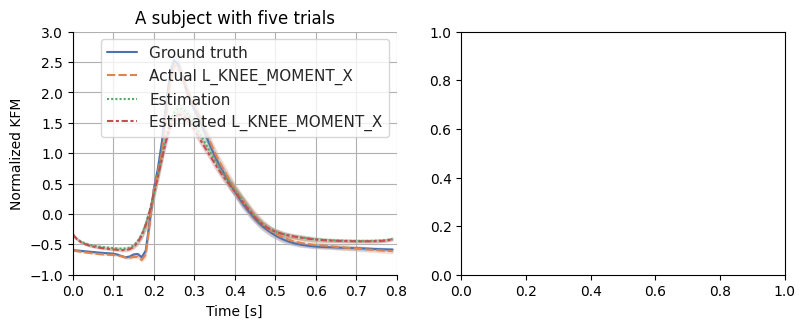

In [8]:
# Plot estimation results of augmentation


combination_investigation_results = [
    #os.path.join(RESULTS_PATH, "training_testing","augmenation_v11_5",str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [1,14] for trial_num in [25]
    os.path.join(RESULTS_PATH, "training_testing","augmenation_v15", str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [1,14] for trial_num in [25]
                                    ]

combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_dkem_v6",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [180]
]

config = {
  'xticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
  'yticks':[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
 'ylim':[-1.0, 3.0],
  'figsize': (8,3),
  'ylabels': 5*['Normalized KFM'],
   'titles': ['A subject with five trials', '14 subjects with 25 trials'],
  'font_scale':1.0, 
   'save_fig': True,
    'fig_path': os.path.join(RESULTS_PATH,"training_testing/visualization/P6","Fig_results_augmentation_curves.svg"),
    'save_format': '.svg'
}

figpath, multi_model_results = p6plot_statistic_actual_estimation_curves(combination_investigation_results, col_wrap=2, **config)

### Augmentation heatmap

/media/suntao/DATA/drop_landing_workspace/results/training_testing/augmentation_dkem_v6/180rotid/14sub/25tri/testing_result_folders.txt
/media/suntao/DATA/drop_landing_workspace/results/training_testing/augmentation_dkem_v6/180rotid/14sub/25tri/metrics.csv
DROP R2 cases below :0.2
provided fig_path is wrong, please give a complete path


/tmp/ipykernel_44116/3652970570.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = aug_metrics[['train_sub_num', 'trial_num', metric_index]].groupby(['train_sub_num','trial_num']).median().round(2).reset_index().pivot('train_sub_num','trial_num')[metric_index]


UnboundLocalError: local variable 'figPath' referenced before assignment

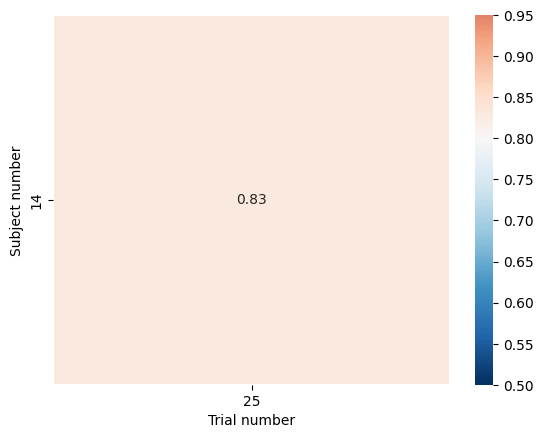

In [5]:
# imu augmentation
combination_investigation_results = [ 
    os.path.join(RESULTS_PATH, "training_testing","augmentation_v11_5", str(train_sub_num)+"sub", str(trial_num)+"trials",
                 "testing_result_folders.txt") for train_sub_num in range(1,15,1) for trial_num in range(5,26,5)]


combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_kem_v3",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(2,15,1) for trial_num in range(25, 26,5) for rot_id in [6]
]

combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_dkem_v6",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(14,15,1) for trial_num in range(25, 26,5) for rot_id in [180]
]

metrics = get_list_investigation_metrics(combination_investigation_results)

combination_investigation_metrics = [os.path.join(os.path.dirname(folder), "metrics.csv") for folder in combination_investigation_results]
metric_index='r2'
filters={'drop_value':0.2,'sort_variable':metric_index}
aug_metrics = parse_list_investigation_metrics(combination_investigation_metrics,**filters)
#aug_metrics['subject_num'].replace({idx:idx-4 for idx in range(5,11)},inplace=True)

data = aug_metrics[['train_sub_num', 'trial_num', metric_index]].groupby(['train_sub_num','trial_num']).median().round(2).reset_index().pivot('train_sub_num','trial_num')[metric_index]
ax = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.8,annot=True,linewidths=0.3).invert_yaxis()
plt.ylabel('Subject number')
plt.xlabel('Trial number')
save_format='svg'
fig_path = os.path.join(RESULTS_PATH, "visualization/P6/Fig_results_augmentation_heatmap.svg")
save_figure("",fig_path=fig_path,fig_format=save_format)



In [6]:

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","investigation_imu_augment_v2",str(trial_idx)+"trials",str(sub_idx)+"sub","testing_result_folders.txt") for sub_idx in range(1,15,1) for trial_idx in range(5,6,5)
]

#metrics = get_list_investigation_metrics(combination_investigation_results)

combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}
#filters={}

aug_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)

NameError: name 'parase_list_investigation_metrics' is not defined

In [ ]:
aug_metrics[['test_subject','child_test_id','r2','subject_num']].groupby(['test_subject', 'subject_num']).mean().round(2).to_csv('ss.csv')

In [ ]:
aug_metrics.head()

In [ ]:
# table

filters={'drop_value':0.0,'sort_variable':'r2'}
aug_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
aug_metrics[['trial_num','subject_num','r2']][aug_metrics['trial_num'].isin([25])].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

## Comparsion

In [ ]:
# compare baseline and imu augmentation
combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","baseline_mlnn_v11_5",
                 str(train_sub_num)+"sub",str(trial_num)+"trials",
                 "testing_result_folders.txt") for train_sub_num in range(1,15,1) for trial_num in range(25,26,5)
                                    ]+ [
    os.path.join(RESULTS_PATH, "training_testing","augmentation_v11_5",
                 str(train_sub_num)+"sub",str(trial_num)+"trials",
                 "testing_result_folders.txt") for train_sub_num in range(1,15,1) for trial_num in range(25,26,5)
                                    ]


combination_investigation_results =  [#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v20",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(1,15,1) for trial_num in range(5, 26,5) for rot_id in [0]
                        ]+[#combination_investigation_results +[
            os.path.join(RESULTS_PATH, "training_testing", "augmentation_kem_v3",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(2,15,1) for trial_num in range(25, 26,5) for rot_id in [6]
]


#metrics = get_list_investigation_metrics(combination_investigation_results)
combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]

#subs = list(set(metrics['alias_name']))
#replace_values = {sub: int(sub.split('v')[1])-1 for sub in subs}
replace_values = {}
replace_values.update({'baseline': 'Baseline', 'finetuning': 'Fine-tuning', 'imu_augment': 'IMU augmentation', 'Normal_DANN': 'DANN', 'DANN': 'TDANN', 'Aug_DANN': 'ADANN'})
replace_values.update({'baseline_mlnn': 'Measured dataset', 'finetuning': 'Fine-tuning', 'augmentation': 'Augmented dataset', 'Normal_DANN': 'DANN', 'DANN': 'TDANN', 'Aug_DANN': 'ADANN'})
print(replace_values)
replace_columns = {'train_sub_num': 'Train subject number', 'trial_num': 'Trial number', 'model_selection':'Dataset'}
test_pairs =(
            [(1,'Measured dataset'), (1,'Augmented dataset')],
            [(2,'Measured dataset'), (2,'Augmented dataset')],
            [(3,'Measured dataset'), (3,'Augmented dataset')],
            [(4,'Measured dataset'), (4,'Augmented dataset')],
            [(5,'Measured dataset'), (5,'Augmented dataset')],
            [(6,'Measured dataset'), (6,'Augmented dataset')],
            [(7,'Measured dataset'), (7,'Augmented dataset')],
            [(8,'Measured dataset'), (8,'Augmented dataset')],
            [(9,'Measured dataset'), (9,'Augmented dataset')],
            [(10,'Measured dataset'), (10,'Augmented dataset')],
            [(11,'Measured dataset'), (11,'Augmented dataset')],
            [(12,'Measured dataset'), (12,'Augmented dataset')],
            [(13,'Measured dataset'), (13,'Augmented dataset')],
            [(14,'Measured dataset'), (14,'Augmented dataset')],
            )


plot_config={
        "save_fig": True, "save_format":"jpg", "save_folder_index": 0,
         'figsize':(8, 5),
         "hue": 'Dataset',
        'replace_values': replace_values,
        'replace_columns': replace_columns,
        'x': 'Train subject number',
        #'y': 'mean_subject_r2',
        'y': 'r2',
        'title': 'baseline',
        'yticks': ( 0.7, 0.8, 0.9, 1.0),
        #'plot_title': 'baseline',
    'filters': {'drop_value':0.0,'sort_variable':'r2'},
    'font_scale': 1.0,
    'plot_type': 'barplot',
    'ttest':True,
    'fig_path': os.path.join(RESULTS_PATH, "visualization/P6/Fig_results_comparison_v2.svg"),
    'test_pairs':test_pairs
    }

filters={'drop_value':0.0,'sort_variable':'r2'}
p6plot_model_accuracy(combination_investigation_metrics, **plot_config)

## Explore augmentation parameters

In [4]:
combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v17",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(15,16,1) for trial_num in range(25, 26,5) for rot_id in [0]
    ]+[
    os.path.join(RESULTS_PATH, "training_testing", "augmentation_v16",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(15,16,1) for trial_num in range(25, 26,5) for rot_id in [10,30]
    ]+[
    os.path.join(RESULTS_PATH, "training_testing", "augmentation_v17",str(rot_id)+'rotid', str(sub_num)+"sub", str(trial_num)+"tri",  
                 "testing_result_folders.txt") for sub_num in range(15,16,1) for trial_num in range(25, 26,5) for rot_id in [50, 70, 90, 110, 130, 150, 170]
    ]

metrics = get_list_investigation_metrics(combination_investigation_results)

/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v17/0rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v16/10rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v16/30rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v17/50rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v17/70rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v17/90rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v17/110rotid/15sub/25tri/testing_result_folders.txt
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v17/130rot

In [ ]:
#metrics['r2']=metrics['r2'].astype(float)
#sns.barplot(data=metrics, x='config_name',y='r2')
#plt.grid()

combination_investigation_metrics = [os.path.join(os.path.dirname(folder), "metrics.csv") for folder in combination_investigation_results]

fig_path, r2 = plot_models_accuracy(combination_investigation_results,plot_params={'x':'config_name','y':'r2', 'hue':'train_sub_num'})

In [ ]:
%run visualization

### Augmentation